# Colorectal Cancer EDA
**Notebook Author: Shweta Chandole** 

Date: Jul 03, 2022

<a id='start'></a>
## Project Details

Create EDA and develop ML classification models to identify the likelihood of a cancer diagnosis for a patient based on the symptoms reported early on in the consultation process. This project makes use of the colorectal cancer and lung cancer datasets.

## Importing Libraries

In [50]:
# import libraries for data manipulation
import numpy as np
import pandas as pd
from numpy import mean, std

# import libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# import library for preparing data
import sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer
import statsmodels.api as sm
from imblearn.over_sampling import SMOTE

# import libraries for building classifier models
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from statsmodels.graphics.gofplots import ProbPlot

# import libraries for performance metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, balanced_accuracy_score, roc_auc_score 

import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore')

In [183]:
sns.set_theme(context='notebook', style='darkgrid', palette='dark', font='sans-serif', font_scale=1, color_codes=True, rc=None)

## Data Preparation

### Loading the data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
# reading original colrectal dataset
data_crc_orig = pd.read_csv('/content/drive/MyDrive/Data/CRC_original_dataset.csv')

### Understanding the data

In [217]:
# copy dataset to new variables
df_crc = data_crc_orig.copy()

In [218]:
# check for shape and first few records of dataset
df_crc.shape

(2093, 1259)

In [214]:
# check for duplicate records
print(df_crc.duplicated().sum())

0


In [8]:
# check for crc dataset info
df_crc.info(verbose = True, show_counts = True, memory_usage = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2093 entries, 0 to 2092
Data columns (total 1259 columns):
 #     Column                          Non-Null Count  Dtype  
---    ------                          --------------  -----  
 0     Unnamed: 0                      2093 non-null   int64  
 1     abd_tend_score                  2093 non-null   float64
 2     PR_score                        2093 non-null   float64
 3     age_group                       2093 non-null   float64
 4     Case_Control                    2093 non-null   int64  
 5     code_D11_1st                    2093 non-null   float64
 6     code_D11_2nd                    2093 non-null   float64
 7     code_D12_1st                    2093 non-null   float64
 8     code_D12_2nd                    2093 non-null   float64
 9     code_T03_1st                    2093 non-null   float64
 10    code_T03_2nd                    2093 non-null   float64
 11    code_T08_1st                    2093 non-null   float64
 12    co

### Five-point summary analysis

In [10]:
# check for data summary 
df_crc.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,2093.0,1046.000000,604.341377,0.0,523.0,1046.0,1569.00,2092.0
abd_tend_score,2093.0,0.061634,0.240547,0.0,0.0,0.0,0.00,1.0
PR_score,2093.0,0.155280,0.867551,0.0,0.0,0.0,0.00,5.0
age_group,2093.0,1.592929,0.491406,1.0,1.0,2.0,2.00,2.0
Case_Control,2093.0,0.166746,0.372838,0.0,0.0,0.0,0.00,1.0
...,...,...,...,...,...,...,...,...
earliest_severe_anaemia,62.0,-146.935484,113.082426,-359.0,-262.0,-110.5,-46.00,-1.0
severe_anaemia_last_year,2093.0,0.029623,0.169584,0.0,0.0,0.0,0.00,1.0
earliest_FOB,35.0,-123.542857,95.400500,-335.0,-175.5,-82.0,-54.00,-9.0
FOB_last_year,2093.0,0.016722,0.128260,0.0,0.0,0.0,0.00,1.0


In [11]:
df_crc.describe(include=['object']).T

,count,unique,top,freq
definite_check_exclude,349,2,Definite,339
cancer_staging,406,16,Duke's B,123


### Identifying target variable and classes

In [219]:
print("Case_Control: ")
print(df_crc['Case_Control'].value_counts())
print("\nControl_Case: ") 
print(df_crc['Control_Case'].value_counts())

Case_Control: 
0    1744
1     349
Name: Case_Control, dtype: int64

Control_Case: 
1.0    1744
0.0     349
Name: Control_Case, dtype: int64



|index|count|mean|std|min|25%|50%|75%|max|
|---|---|---|---|---|---|---|---|---|
|Case\_Control|2093\.0|0\.16674629718107978|0\.3728382831911263|0\.0|0\.0|0\.0|0\.0|1\.0|
|Control\_Case|2093\.0|0\.8332537028189202|0\.3728382831911263|0\.0|1\.0|1\.0|1\.0|1\.0|


**Observations (CRC Data):**
- Case_Control indicates the binary class distribution in the proportion 1744 Controls studied (class 0) at 83.33% to 349 Cases studied (class 1) at 16.67%
- Class 1 (Cases) is the minoriity class, and also the desired class here since we are looking at early detection
- Column Control_Case shall be dropped due to the redundant nature of this column




## Proposed Design Approach

- Based on "[symptoms_names_only_excl.xlsx](https://docs.google.com/spreadsheets/d/14dWHmPsDGC48P8v-8xCYDxRlPmjJNt_e/edit#gid=842469682)", the dataset may be using the value 0 for variables with either no observed symptoms, or no score for the symptoms or even for missing values in some cases.
- In case of generic data imputation, replacing with 0 could appear as an assumption that missing values concur with no symptom or no score for the symptom, this may result in reducing the impact of records with missing values, and also cause errors in predictions. Hence, this author proposes following methods for data imputation:
  1. a. remove records with missing values, in order to train ML models based on complete data records only ([citation](https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/s12911-022-01752-6))
      
      b. Ensemble learning with only complete records from the dataset (update: No records WITHOUT missing values, so this approach doesn't work)

  2. a. Replace missing values with -1 across dataset, followed by Ensemble learning (only time_before_dendrite columns have negative values, but there are no missing values in them, so it should be safe to replace missing vales with -1)
      
      b. train models based on LR, DT, RF, lightGBM and XGB
    
  3. Use [Histogram-based Gradient Boosting Classification Tree](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html) which has native support for missing values


## Data pre-processing and feature engineering

### Introducing feature: Status 

- Adding column Status to identify Case (Cases i.e. class 0 Vs. Control (Control i.e. class 1)

In [220]:
df_crc.loc[df_crc.Case_Control == 0, 'STATUS'] = 'Control - No Cancer'
df_crc.loc[df_crc.Case_Control == 1, 'STATUS'] = 'Case - Diagnosed'

### Drop Columns

In [221]:
# drop column Control_Case from crc data, which is opposite of Case_control and is redundant for our purpose
df_crc.drop(['Control_Case'], axis=1, inplace = True)

In [222]:
# drop primary key column from crc
df_crc.drop(df_crc.columns[[0]], axis = 1, inplace = True)
df_crc

,abd_tend_score,PR_score,age_group,Case_Control,code_D11_1st,code_D11_2nd,code_D12_1st,code_D12_2nd,code_T03_1st,code_T03_2nd,...,earliest_rectal_bleeding,rectal_bleeding_last_year,earliest_mild_anaemia,mild_anaemia_last_year,earliest_severe_anaemia,severe_anaemia_last_year,earliest_FOB,FOB_last_year,diarrhoea_duration,STATUS
0,0.0,0.0,1.0,0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,NaN,0.0,NaN,0.0,NaN,0.0,22.0,Control - No Cancer
1,0.0,0.0,1.0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,Control - No Cancer
2,0.0,0.0,2.0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,Control - No Cancer
3,0.0,0.0,1.0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,Control - No Cancer
4,0.0,0.0,2.0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,Control - No Cancer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2088,0.0,0.0,2.0,1,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,NaN,0.0,-94.0,1.0,NaN,0.0,NaN,Case - Diagnosed
2089,0.0,0.0,1.0,1,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,Case - Diagnosed
2090,0.0,0.0,2.0,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,Case - Diagnosed
2091,0.0,0.0,2.0,1,0.0,0.0,0.0,0.0,1.0,0.0,...,-22.0,1.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,Case - Diagnosed


In [223]:
# drop empty columns from crc, if any
df_crc.dropna(1, 'all')
df_crc.shape

(2093, 1258)

### Rename select features

In [224]:
df_crc_select = df_crc.copy()
df_crc_select.shape

(2093, 1258)

In [ ]:
# renaming select features based on Prof. Hamilton's reference research papers
df_crc_select.rename(columns = {'code_D11_1st' : 'diarrhoea',
'code_D12_1st' : 'constipation',
'code_T03_1st' : 'loss_of_appetite',
'code_T08_1st' : 'weight_loss',
'code_D16_1st' : 'rectal_bleeding',
'code_D01_1st' : 'abdominal_pain_general',
'code_D06_1st' : 'abdominal_pain_localized',
'code_D09_1st' :	'nausea',
'code_D10_1st' :	'vomiting',
'code_D01_frequency' : 'abdo_pain_gen_freq',
'code_D06_frequency' : 'abdo_pain_loc_freq',
'code_D10_frequency' : 'vom_freq',
'code_D11_frequency' : 'dirh_freq',
'code_D16_frequency' : 'RB_freq',
'LOW_score'	:	'loss_of_weight_score'
}, inplace=True)
#print(df_crc_select.columns)

In [226]:
renamed_cols = ['diarrhoea',
'constipation',
'loss_of_appetite',
'weight_loss',
'rectal_bleeding',
'abdominal_pain_general',
'abdominal_pain_localized',
'nausea',
'vomiting',
'abdo_pain_gen_freq',
'abdo_pain_loc_freq',
'vom_freq',
'dirh_freq',
'RB_freq',
'loss_of_weight_score']

In [ ]:
#df_crc_select[renamed_cols]

### Feature Selection

In [142]:
crc_spec_cols = ["Case_Control",
"STATUS",
"Sex",
"age_at_dendrite_date",
"age_case",
"age_band",
"age_group",
"definite_check_exclude",
"cancer_staging"]

In [230]:
crc_symp_cols = ["Case_Control",
                 "Sex",
                 "loss_of_appetite",
"weight_loss",
"abdominal_pain",
"abdominal_pain_general",
"abdominal_pain_localized",
"nausea",
"vomiting",
"diarrhoea",
"constipation",
"rectal_bleeding",
"haematochezia",
"inv_FOB_positive"]

In [136]:
crc_symp_freq_cols = ["abdominal_pain_frequency",
"abdo_pain_gen_freq",
"abdo_pain_loc_freq",
"vom_freq",
"dirh_freq",
"RB_freq"]

In [137]:
crc_symp_score_cols = ["loss_of_weight_score",
"abdo_pain_score",
"diarrhoea_score",
"constipation_score",
"RB_score",
"FOB_score",
"anaemia_score"]

In [138]:
crc_diab_cols = ["diabetes_tested",
"labelled_diabetic",
"diabetic_control_poor",
"sugar_score"]

In [139]:
crc_inv_cols = ["inv_BP_normal_1st",
"inv_BP_raised_1st",
"inv_Ba_enema_Ca_suspected",
"inv_Ba_enema_abnormal",
"inv_CXR_abnormal",
"inv_CXR_normal",
"inv_ECG_normal",
"inv_MSU_RBC_abnormal",
"inv_MSU_RBC_normal",
"inv_MSU_WCC_abnormal",
"inv_MSU_WCC_normal",
"inv_MSU_growth_positive",
"inv_MSU_no_growth",
"inv_PR_Ca_suspected",
"inv_PR_abnormal",
"inv_PR_normal_1st",
"inv_abdo_US_abnormal",
"inv_abdo_US_normal",
"inv_cervical_smear_normal",
"inv_colonoscopy_abnormal",
"inv_colonoscopy_normal",
"inv_other_XR_abnormal",
"inv_other_XR_normal",
"inv_stool_culture_negative",
"inv_FOB_positive",
"inv_urinalysis_normal_1st",
"inv_urinalysis_normal_2nd"]

In [189]:
crc_other_symp_cols = ["code_D02_1st",
"code_D03_1st",
"code_D07_1st",
"code_D08_1st",
"code_D17_1st",
"code_D18_1st",
"code_D19_1st",
"code_D20_1st",
"code_D21_1st",
"code_D23_1st",
"code_D24_1st",
"code_D25_1st",
"code_D29_1st",
"code_D78_1st",
"code_D92_1st",
"code_D93_1st",
"code_D99_1st"]

## Exploratory Data Analysis

### Univariate Analysis

#### Patient Characteristics

Case_Control
Skew : 1.79


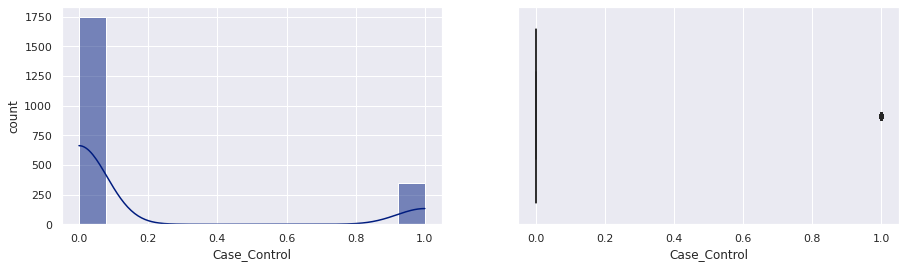

Sex
Skew : 0.03


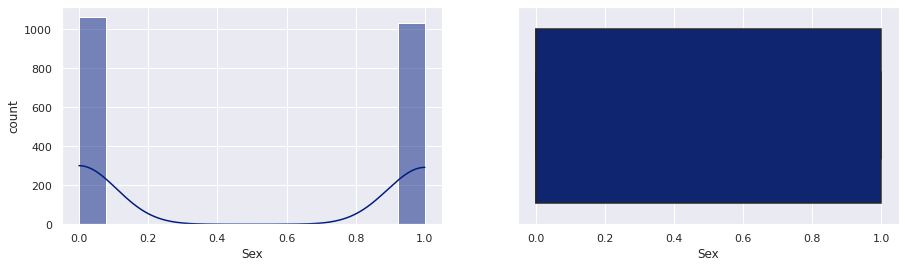

age_at_dendrite_date
Skew : -0.38


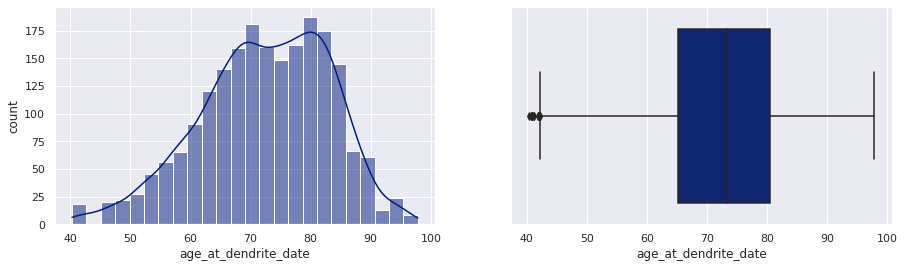

age_case
Skew : -0.38


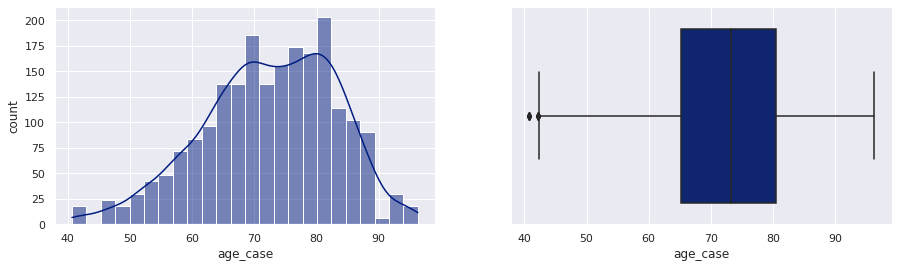

age_band
Skew : -0.23


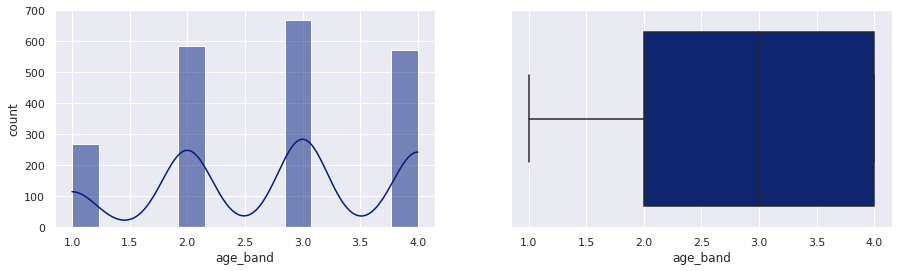

age_group
Skew : -0.38


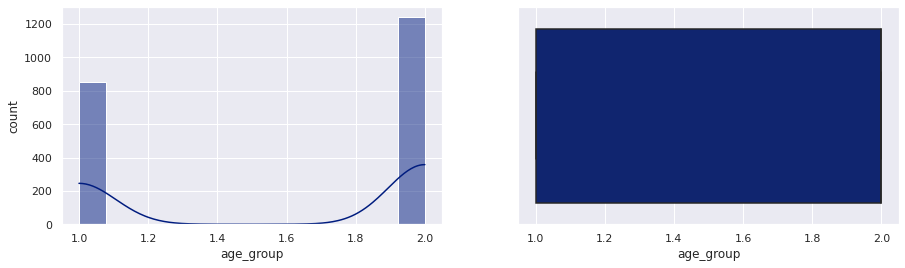

In [182]:
# Univariate analysis - patient characteristics
for col in crc_spec_cols:
    if df_crc_select[col].dtype == 'object' : continue
    print(col)
    print('Skew :',round(df_crc_select[col].skew(),2))
    plt.figure(figsize=(15,4))
    plt.subplot(1,2,1)
    sns.histplot(data=df_crc_select, x=col, kde = True)
    #df2[col].hist(bins = 20, grid = False)
    plt.ylabel('count')
    plt.subplot(1,2,2)
    sns.boxplot(x=df_crc_select[col])
    plt.show()

#### Selected Symptoms

loss_of_appetite
Skew : 3.32


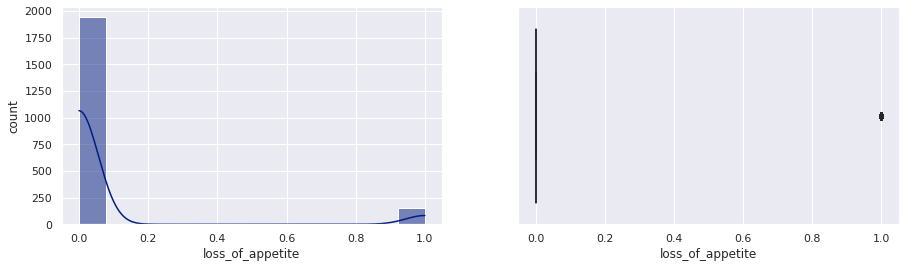

weight_loss
Skew : 2.89


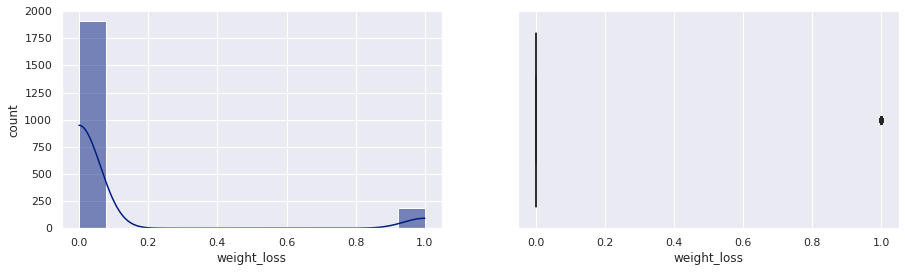

abdominal_pain
Skew : 1.98


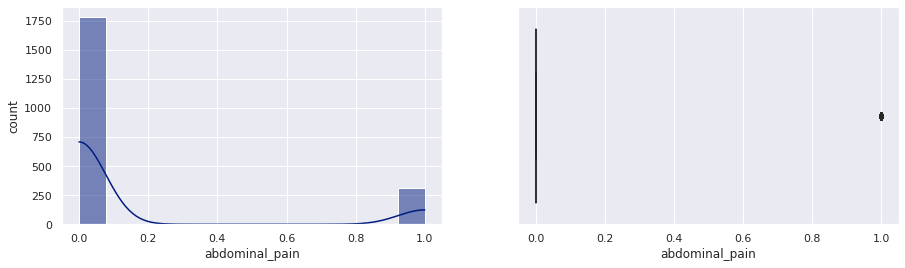

abdominal_pain_general
Skew : 3.13


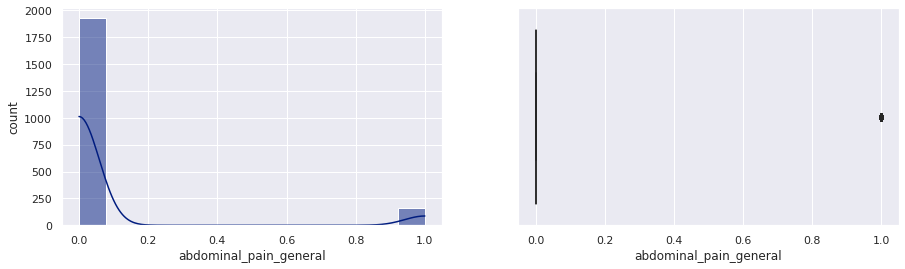

abdominal_pain_localized
Skew : 2.82


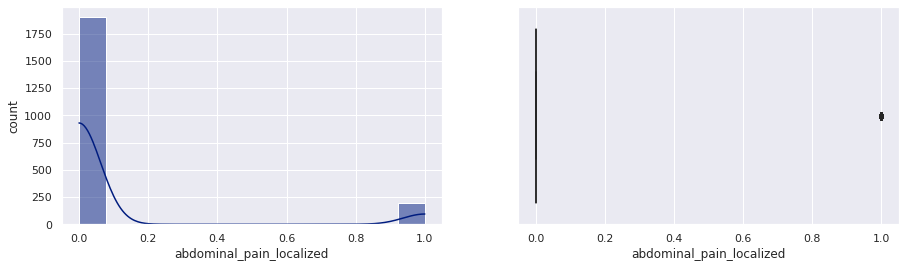

nausea
Skew : 2.82


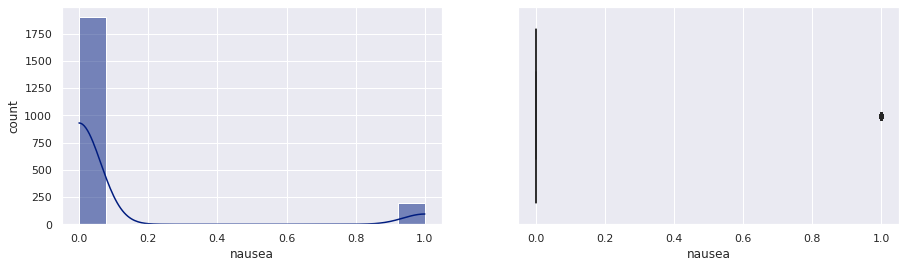

vomiting
Skew : 2.76


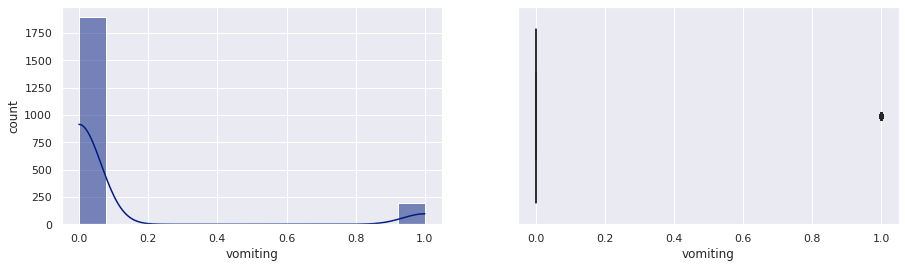

diarrhoea
Skew : 2.02


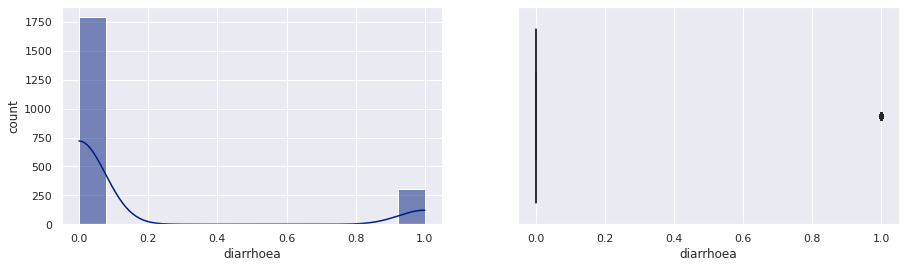

constipation
Skew : 2.43


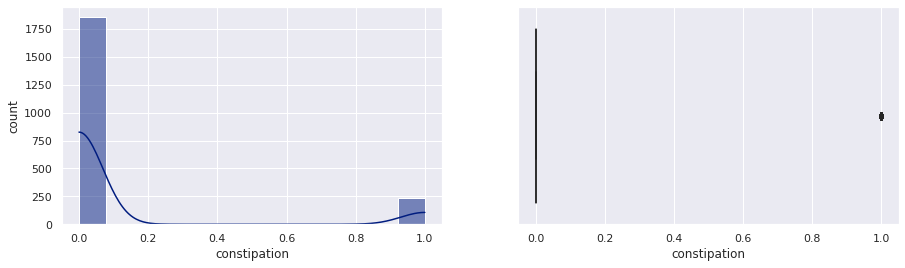

rectal_bleeding
Skew : 2.83


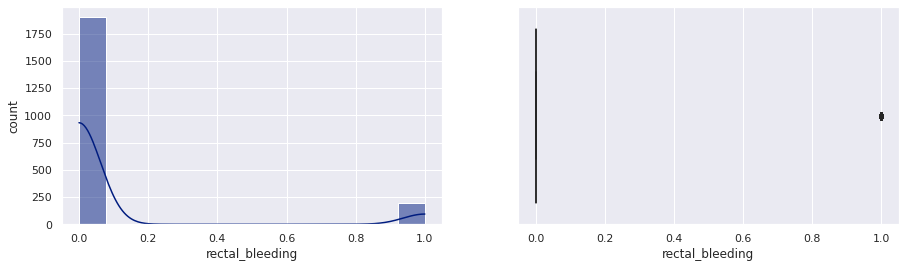

haematochezia
Skew : 2.57


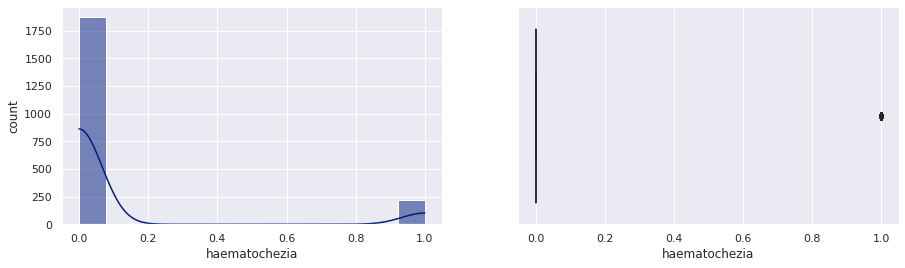

inv_FOB_positive
Skew : 7.43


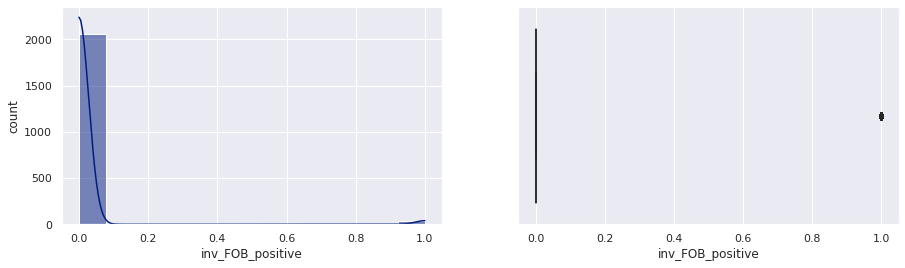

In [187]:
# Univariate analysis - select symptoms
for col in crc_symp_cols:
    if df_crc_select[col].dtype == 'object' : continue
    print(col)
    print('Skew :',round(df_crc_select[col].skew(),2))
    plt.figure(figsize=(15,4))
    plt.subplot(1,2,1)
    sns.histplot(data=df_crc_select, x=col, kde = True)
    #df2[col].hist(bins = 20, grid = False)
    plt.ylabel('count')
    plt.subplot(1,2,2)
    sns.boxplot(x=df_crc_select[col])
    plt.show()

#### Symptoms Frequency and Scores

abdominal_pain_frequency
Skew : 4.77


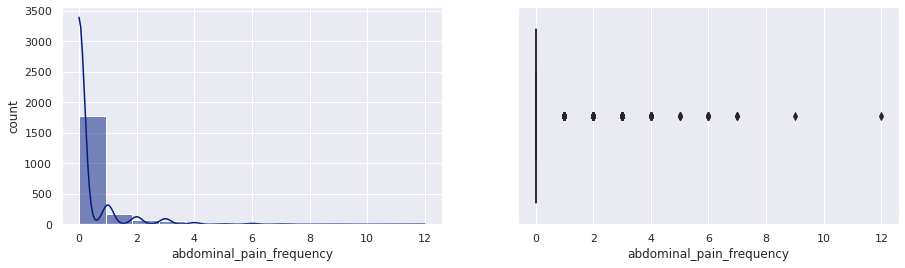

abdo_pain_gen_freq
Skew : 5.11


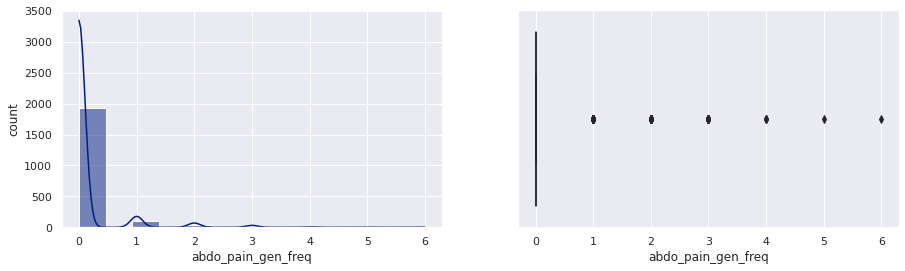

abdo_pain_loc_freq
Skew : 6.23


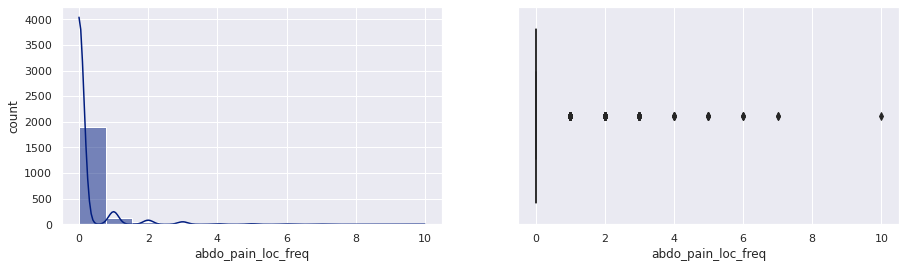

vom_freq
Skew : 6.59


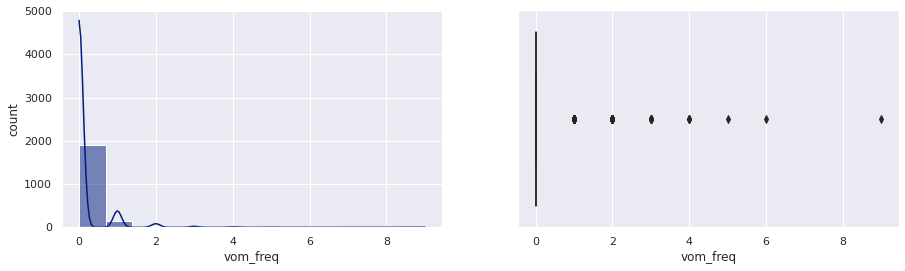

dirh_freq
Skew : 4.91


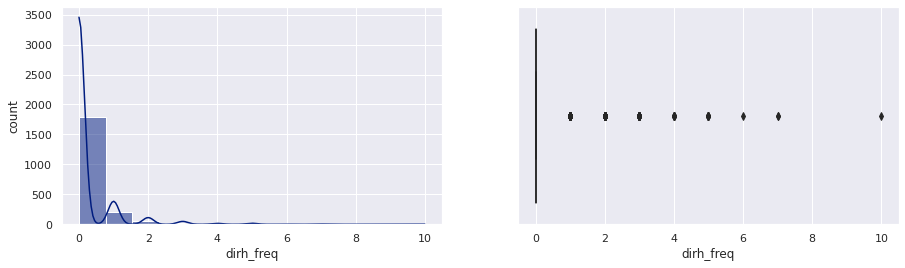

RB_freq
Skew : 5.4


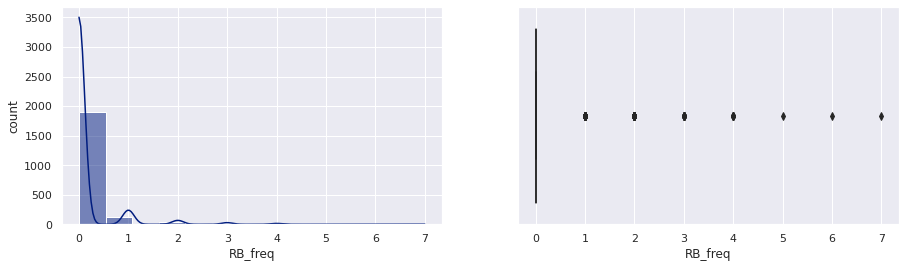

loss_of_weight_score
Skew : 2.89


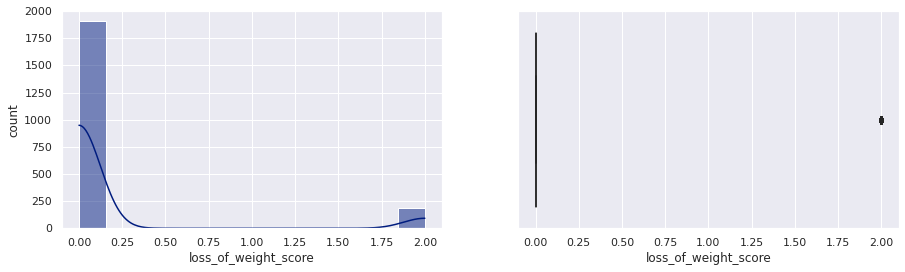

abdo_pain_score
Skew : 2.91


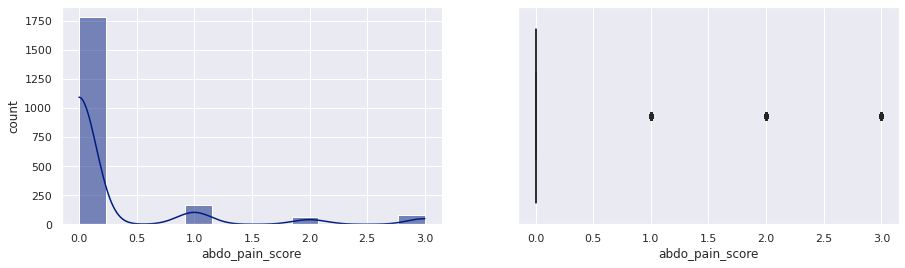

diarrhoea_score
Skew : 4.01


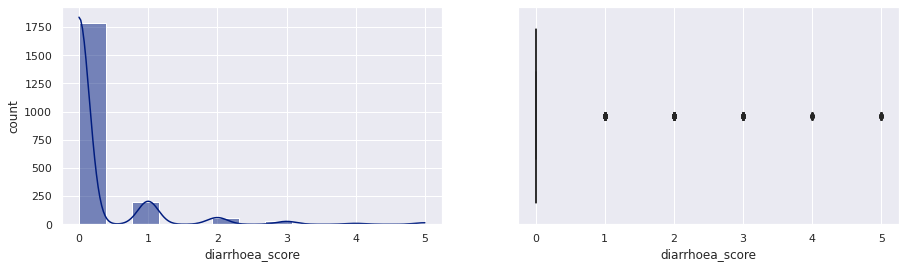

constipation_score
Skew : 2.43


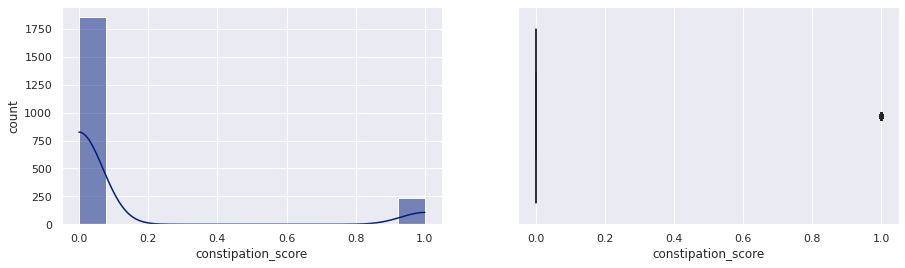

RB_score
Skew : 2.57


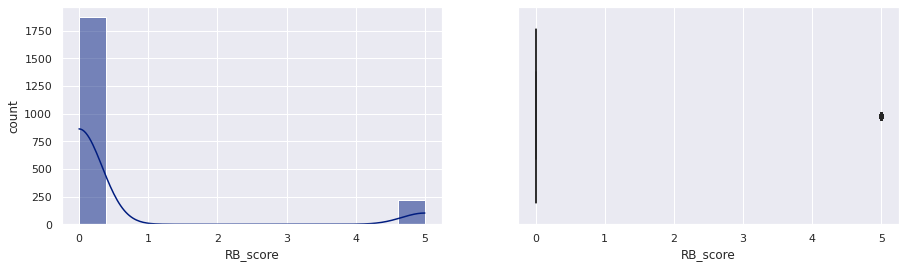

FOB_score
Skew : 7.43


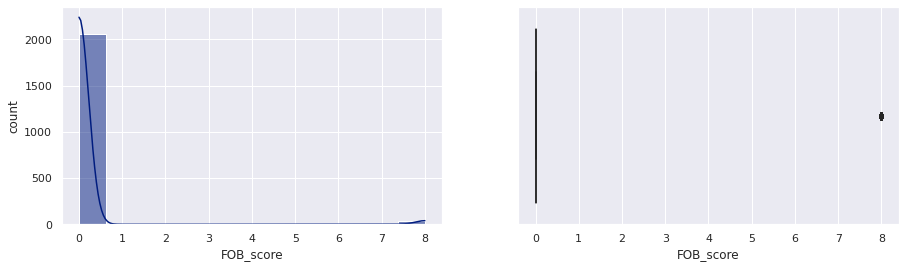

anaemia_score
Skew : 2.65


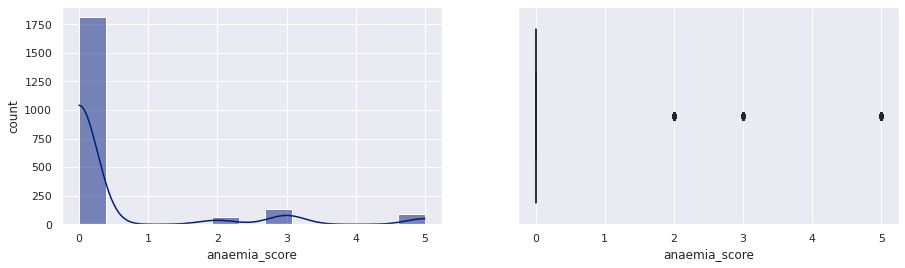

In [192]:
# Univariate analysis - symptom frequency and scores
for col in crc_symp_freq_cols+crc_symp_score_cols:
    if df_crc_select[col].dtype == 'object' : continue
    print(col)
    print('Skew :',round(df_crc_select[col].skew(),2))
    plt.figure(figsize=(15,4))
    plt.subplot(1,2,1)
    sns.histplot(data=df_crc_select, x=col, kde = True)
    #df2[col].hist(bins = 20, grid = False)
    plt.ylabel('count')
    plt.subplot(1,2,2)
    sns.boxplot(x=df_crc_select[col])
    plt.show()

#### Other Symptoms

code_D02_1st
Skew : 3.35


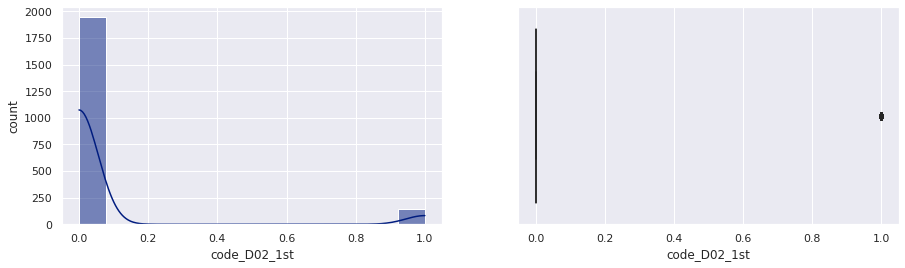

code_D03_1st
Skew : 6.68


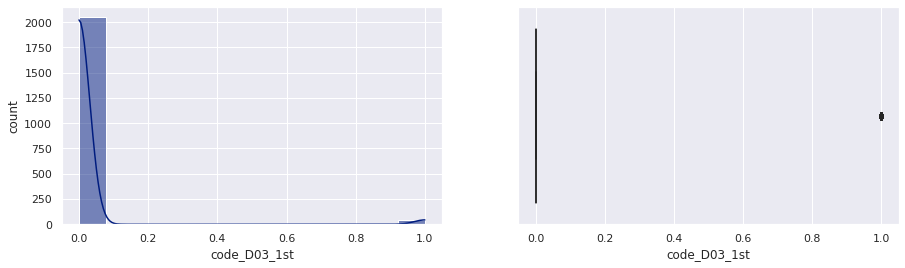

code_D07_1st
Skew : 3.2


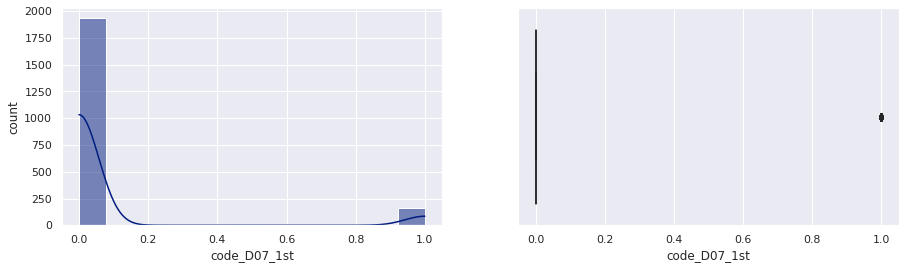

code_D08_1st
Skew : 3.72


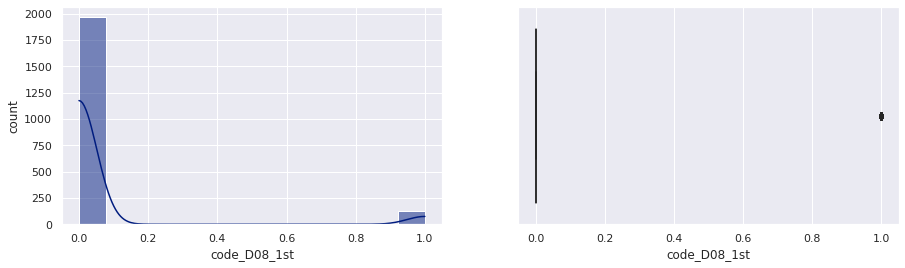

code_D17_1st
Skew : 7.91


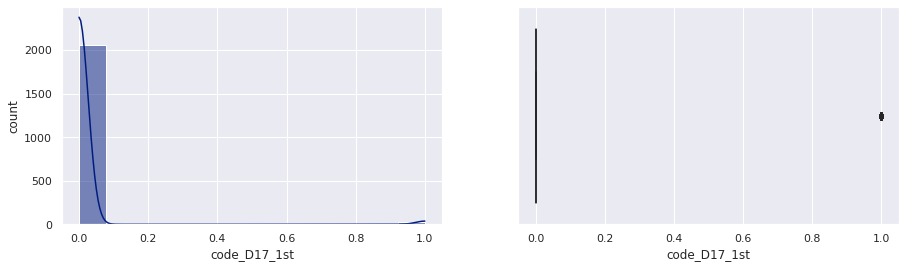

code_D18_1st
Skew : 3.5


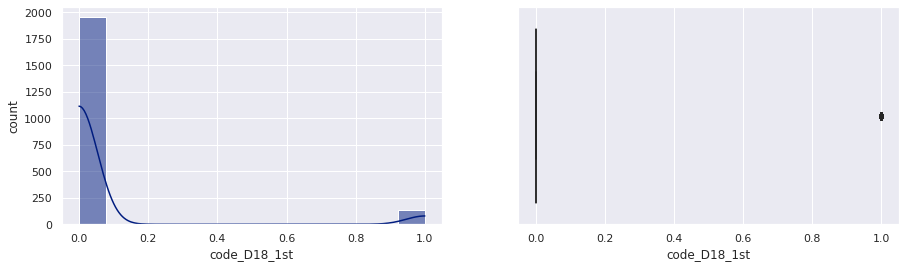

code_D19_1st
Skew : 7.22


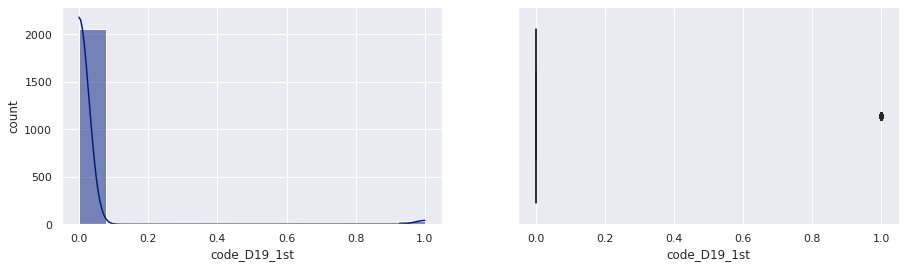

code_D20_1st
Skew : 4.48


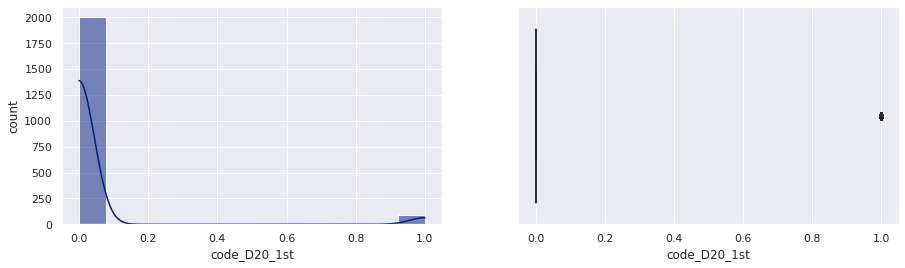

code_D21_1st
Skew : 7.43


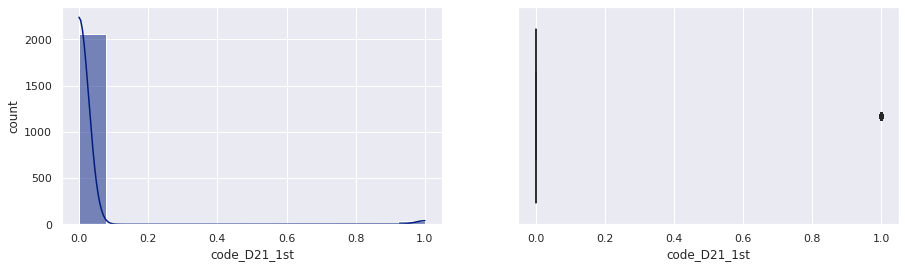

code_D23_1st
Skew : 10.36


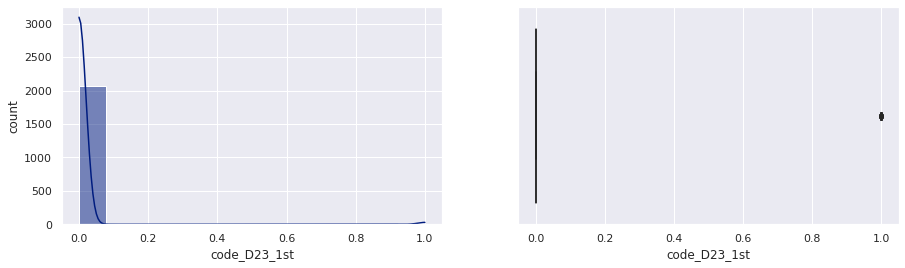

code_D24_1st
Skew : 6.85


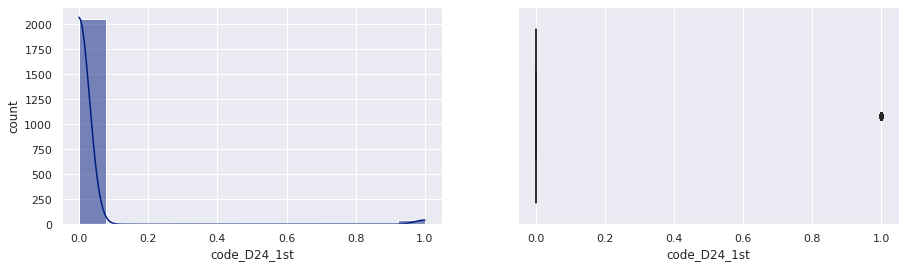

code_D25_1st
Skew : 6.24


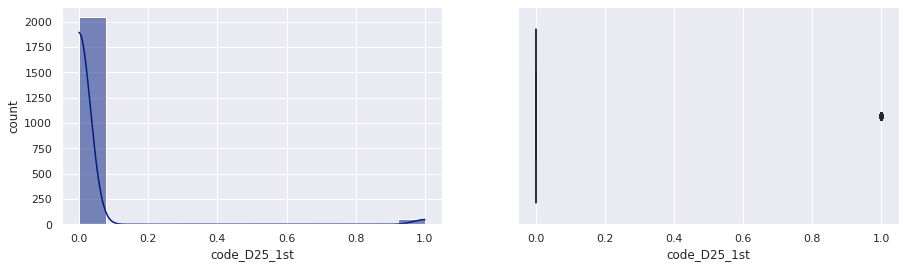

code_D29_1st
Skew : 7.91


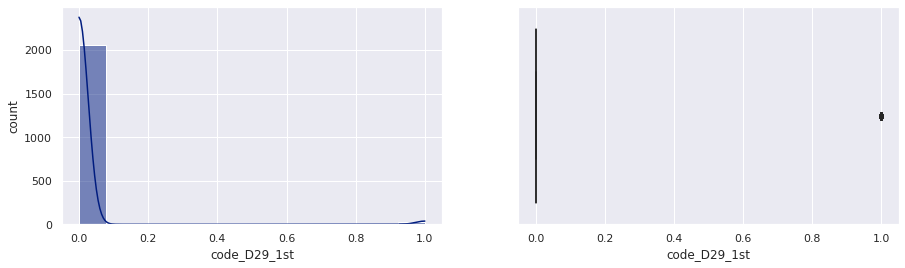

code_D78_1st
Skew : 8.64


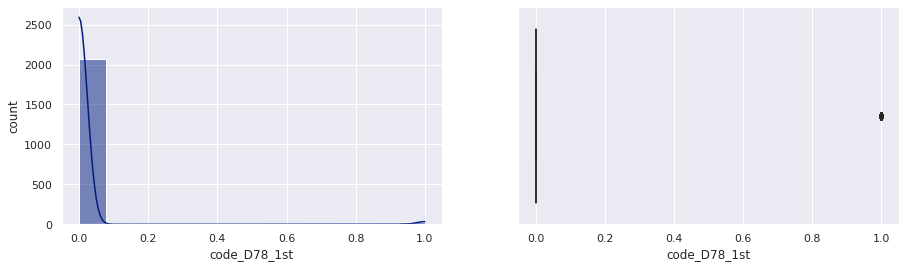

code_D92_1st
Skew : 5.24


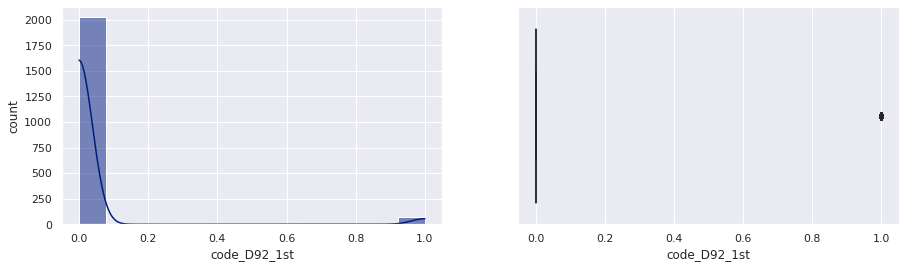

code_D93_1st
Skew : 5.6


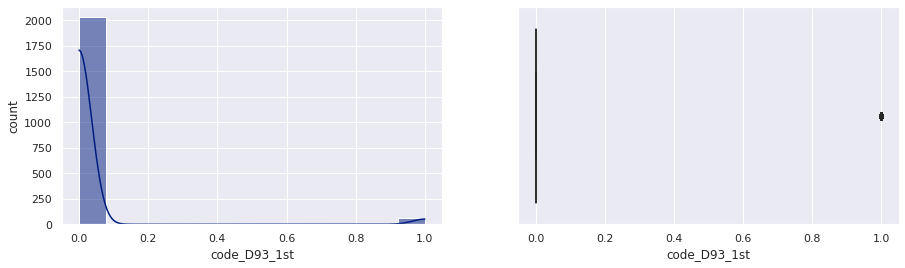

code_D99_1st
Skew : 8.48


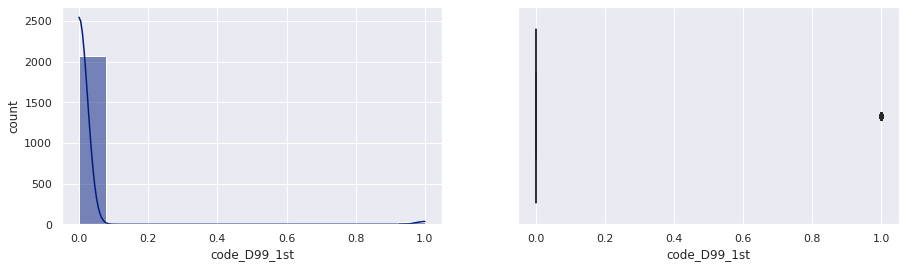

In [190]:
# Univariate analysis - other symptoms
for col in crc_other_symp_cols:
    if df_crc_select[col].dtype == 'object' : continue
    print(col)
    print('Skew :',round(df_crc_select[col].skew(),2))
    plt.figure(figsize=(15,4))
    plt.subplot(1,2,1)
    sns.histplot(data=df_crc_select, x=col, kde = True)
    #df2[col].hist(bins = 20, grid = False)
    plt.ylabel('count')
    plt.subplot(1,2,2)
    sns.boxplot(x=df_crc_select[col])
    plt.show()

### Bivariate Analysis

#### Selected Symptoms vs. cancer case status

loss_of_appetite


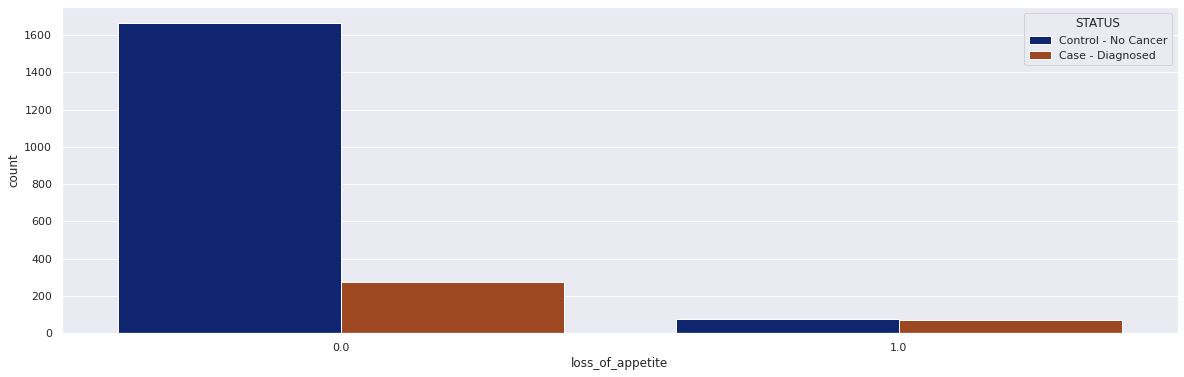



weight_loss


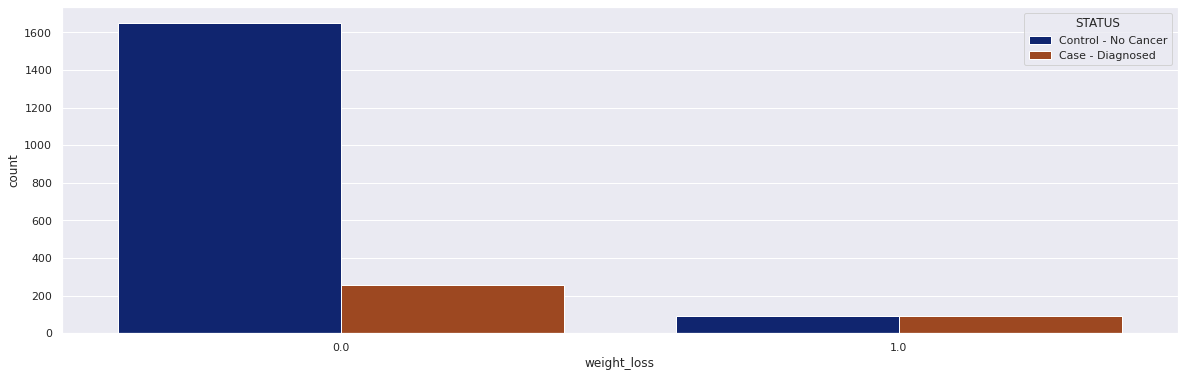



abdominal_pain


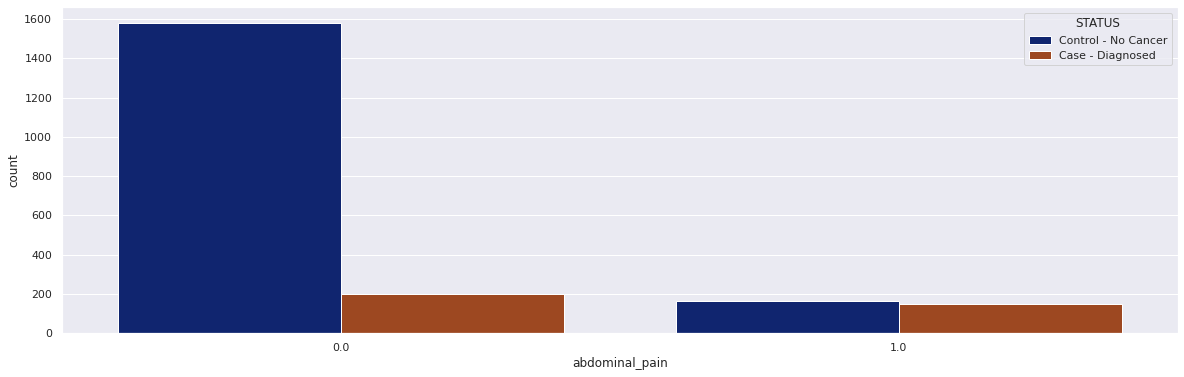



abdominal_pain_general


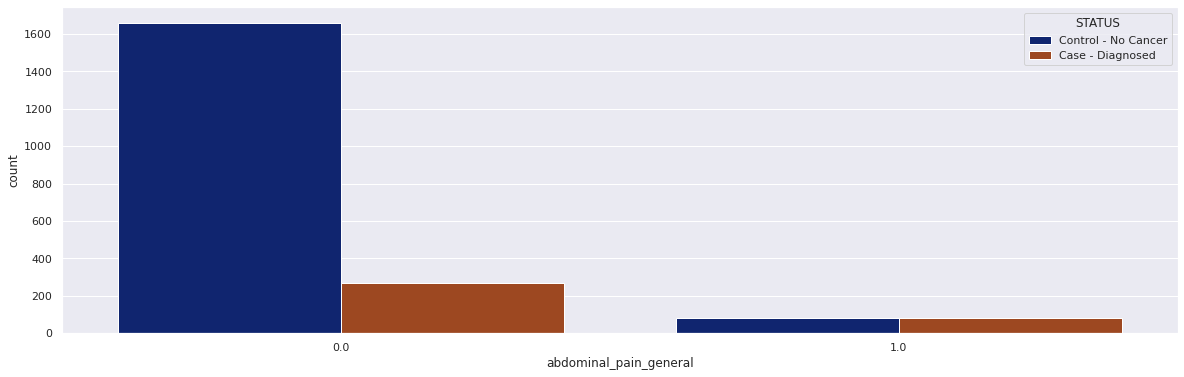



abdominal_pain_localized


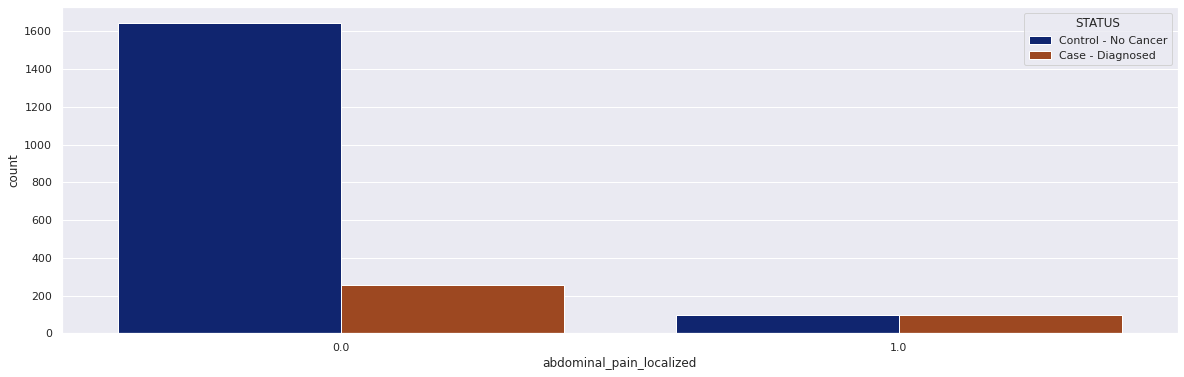



nausea


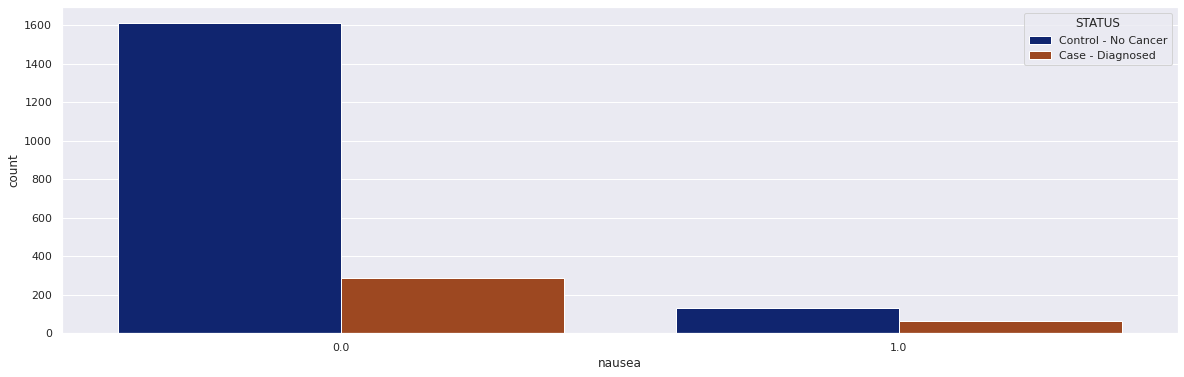



vomiting


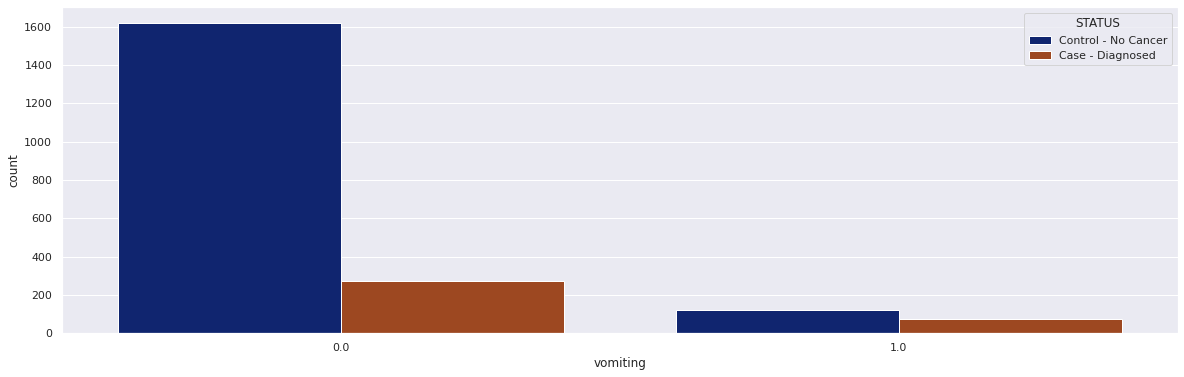



diarrhoea


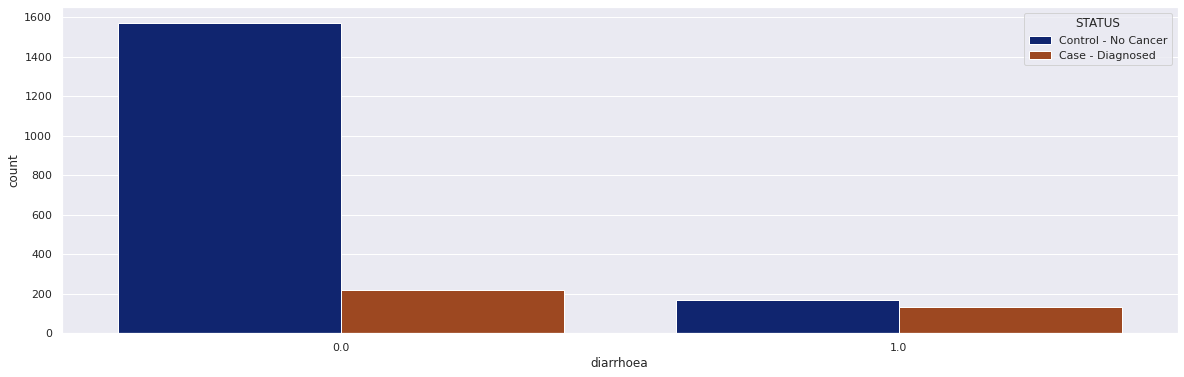



constipation


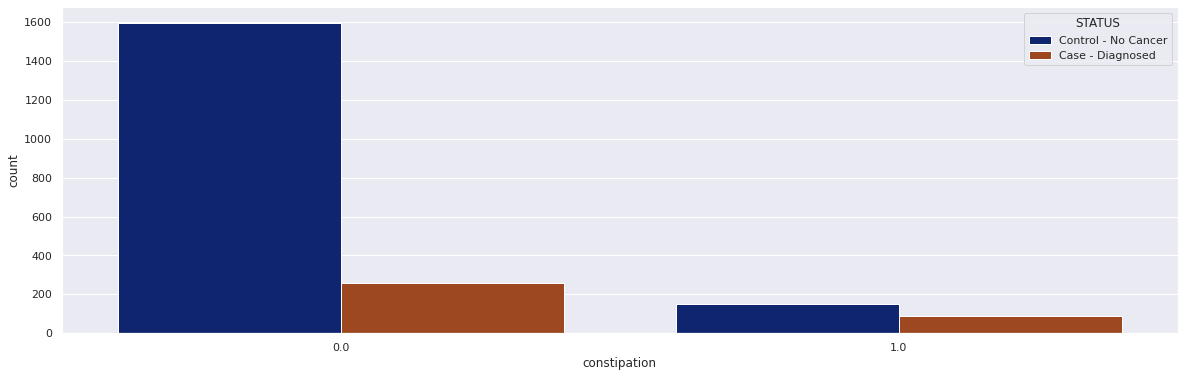



rectal_bleeding


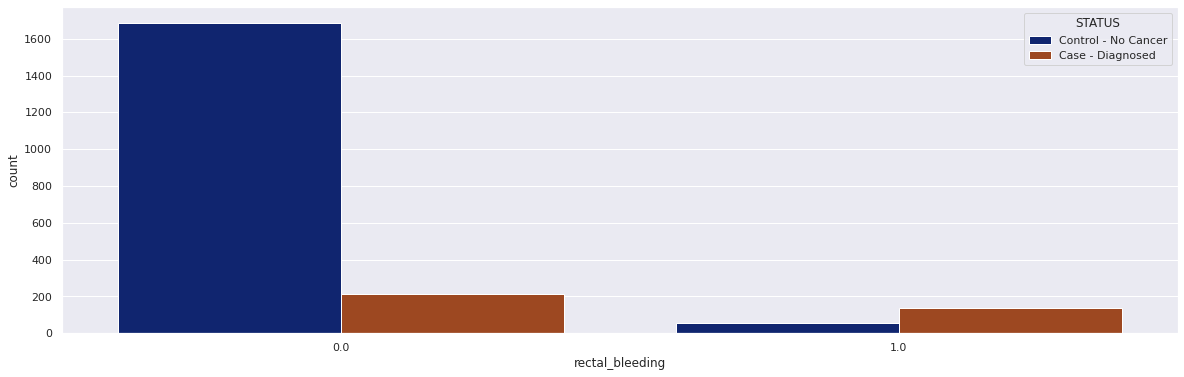



haematochezia


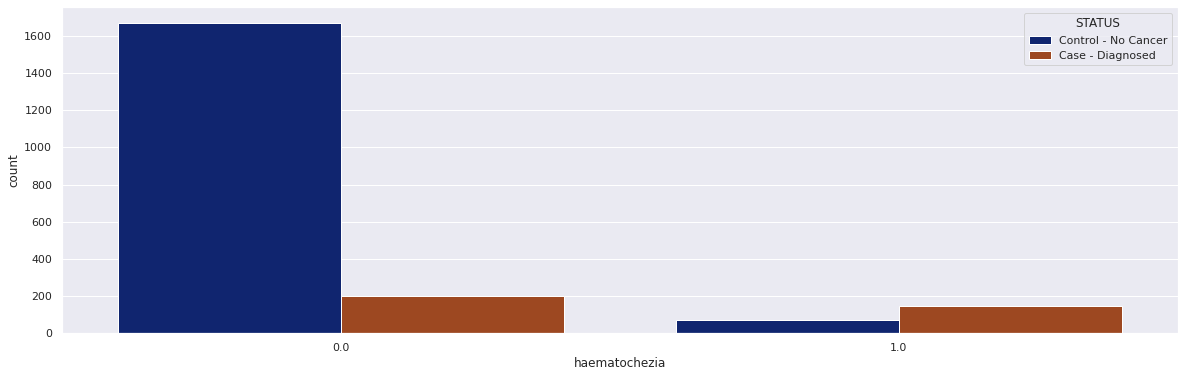



inv_FOB_positive


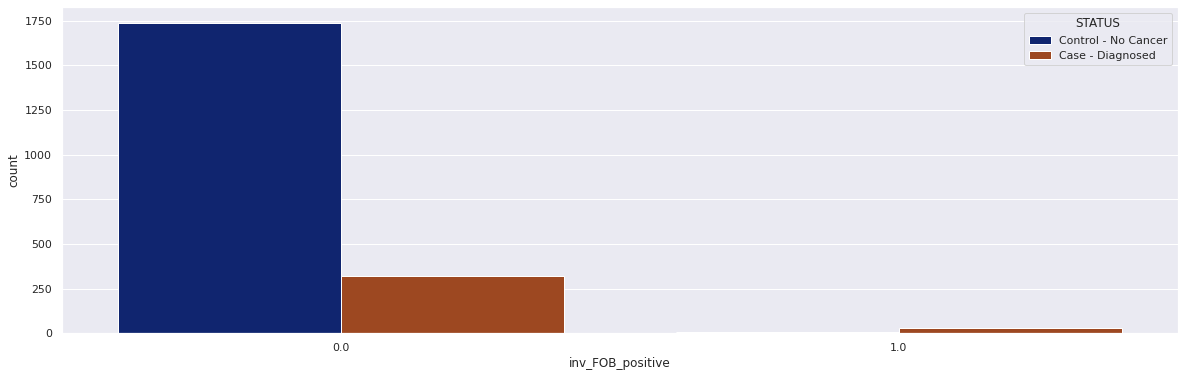

In [193]:
# Bivariate analysis - symptoms vs. cancer case status
for i in crc_symp_cols:
    print(i)
    plt.figure(figsize=(20, 6))
    sns.countplot(x = df_crc_select[i], hue='STATUS', data=df_crc_select)
    plt.show()
    print('\n')

#### Symptoms Frequency vs. cancer case status

abdominal_pain_frequency


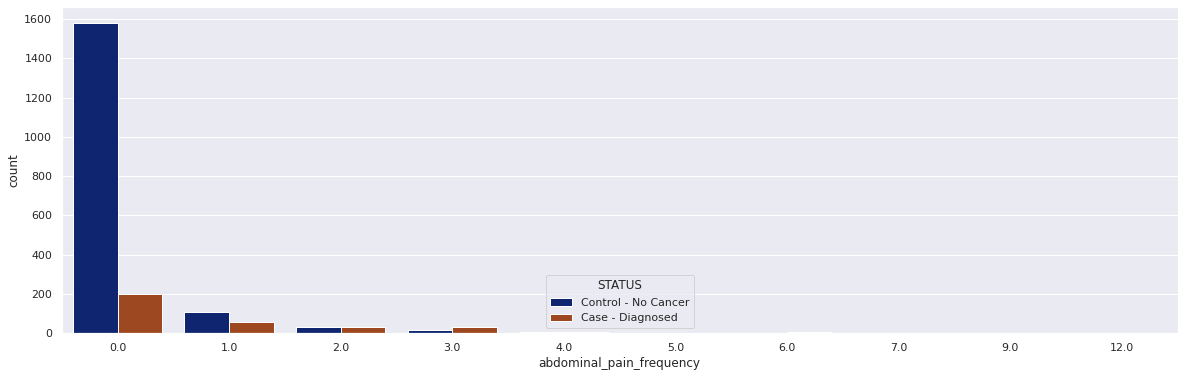



abdo_pain_gen_freq


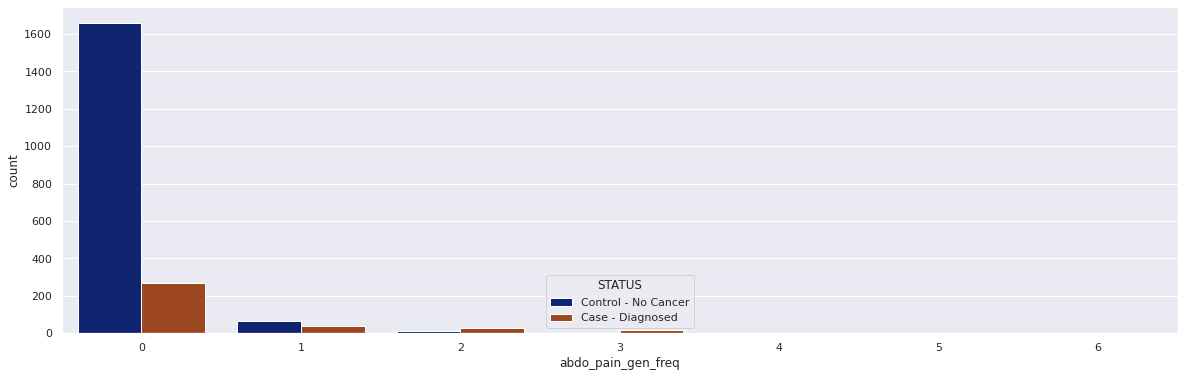



abdo_pain_loc_freq


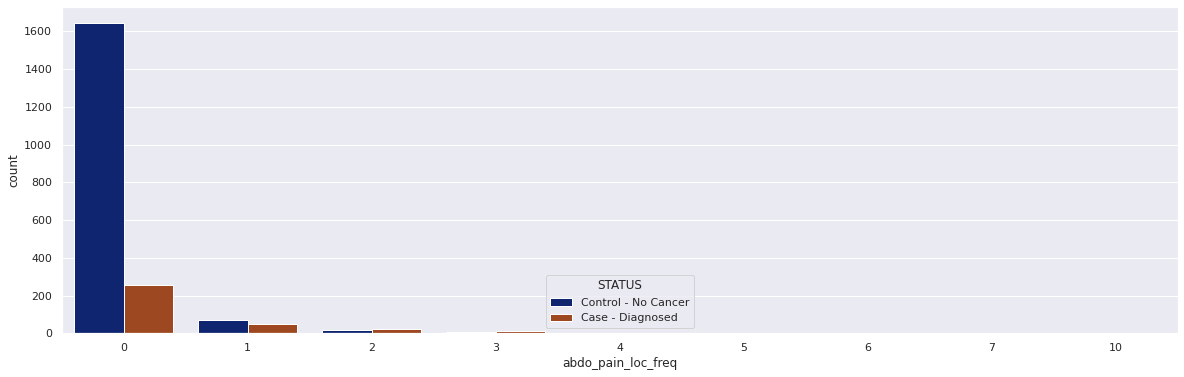



vom_freq


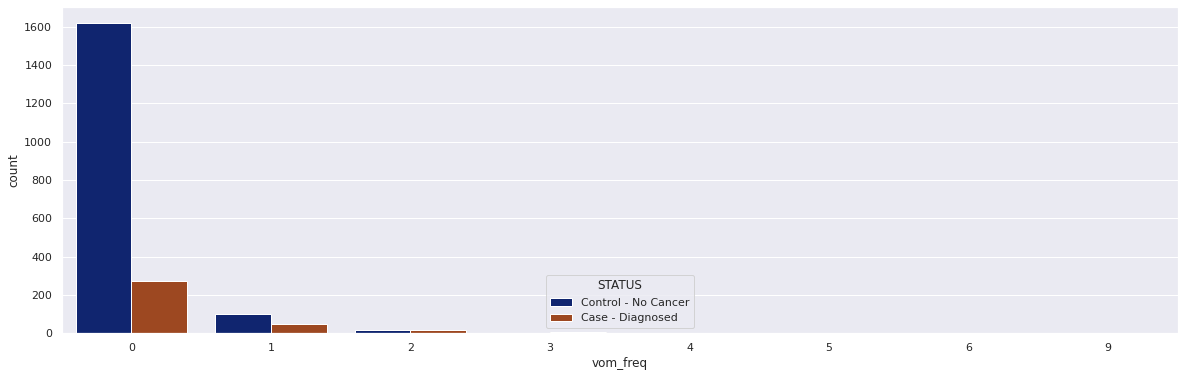



dirh_freq


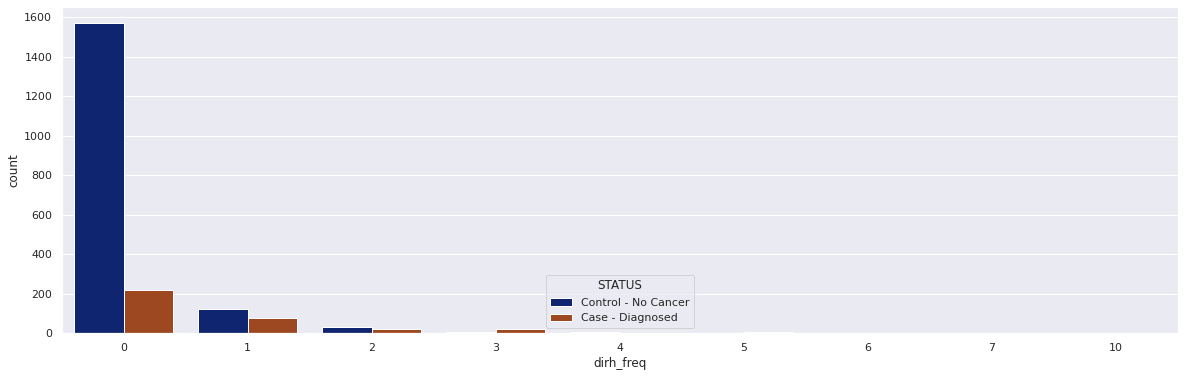



RB_freq


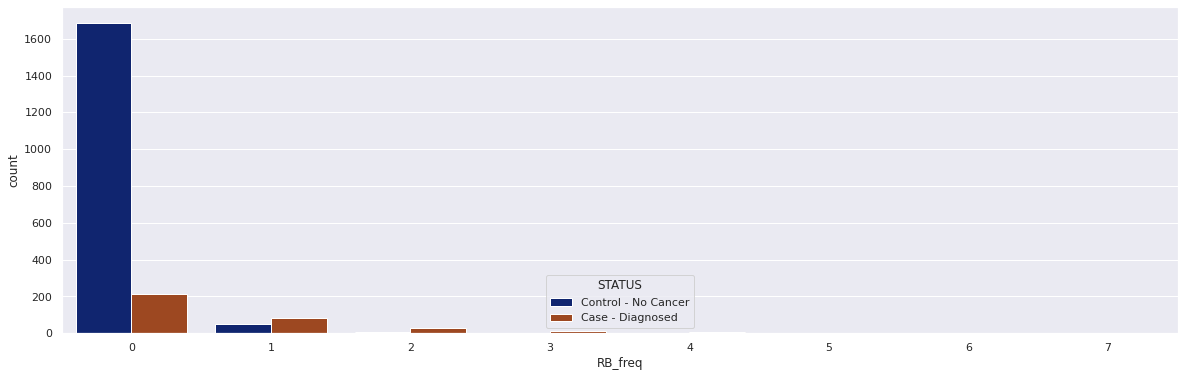

In [195]:
# Bivariate analysis - Symptom Freq vs. cancer case status
for i in crc_symp_freq_cols:
    print(i)
    plt.figure(figsize=(20, 6))
    sns.countplot(x = df_crc_select[i], hue='STATUS', data=df_crc_select)
    plt.show()
    print('\n')

#### Symptom Scores vs. cancer case status

loss_of_weight_score


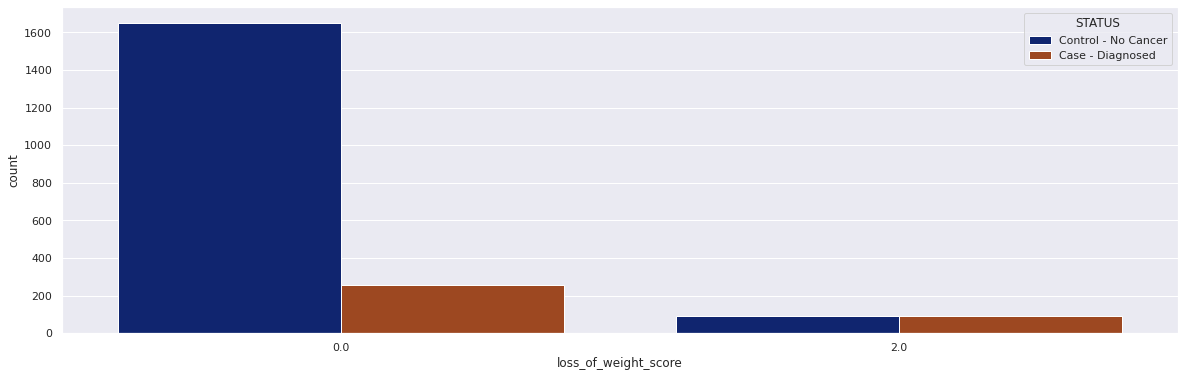



abdo_pain_score


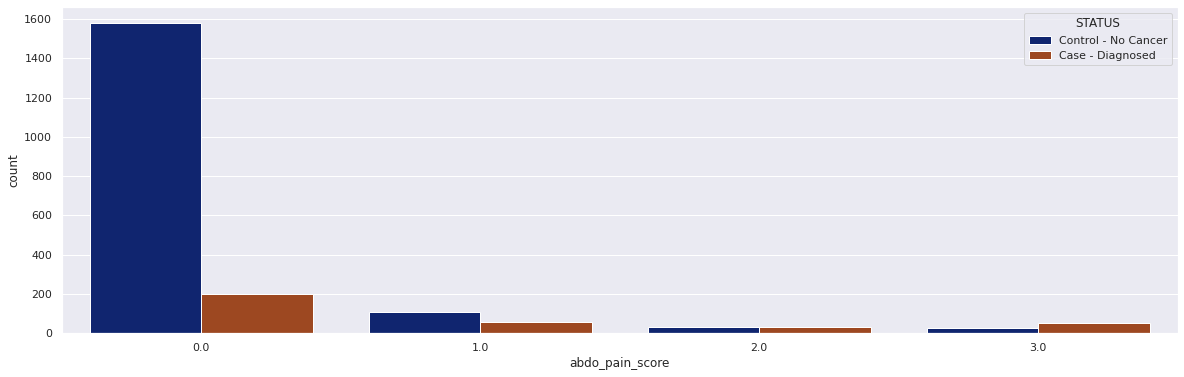



diarrhoea_score


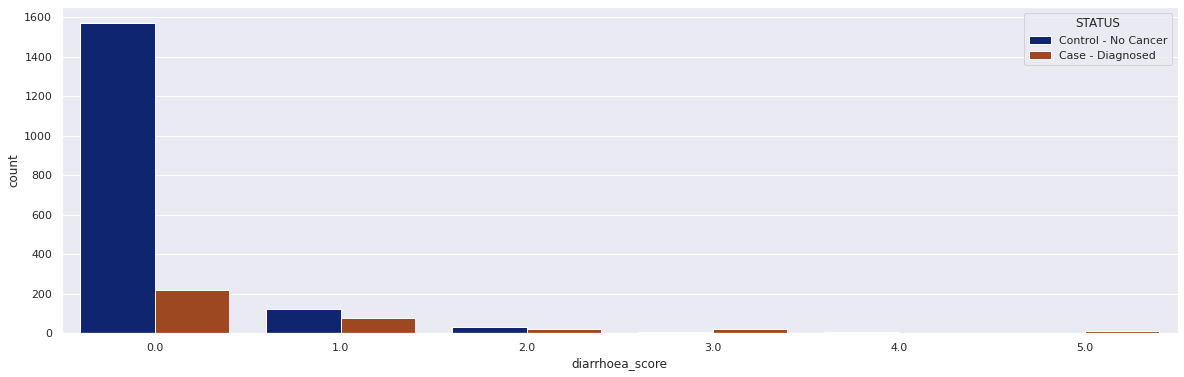



constipation_score


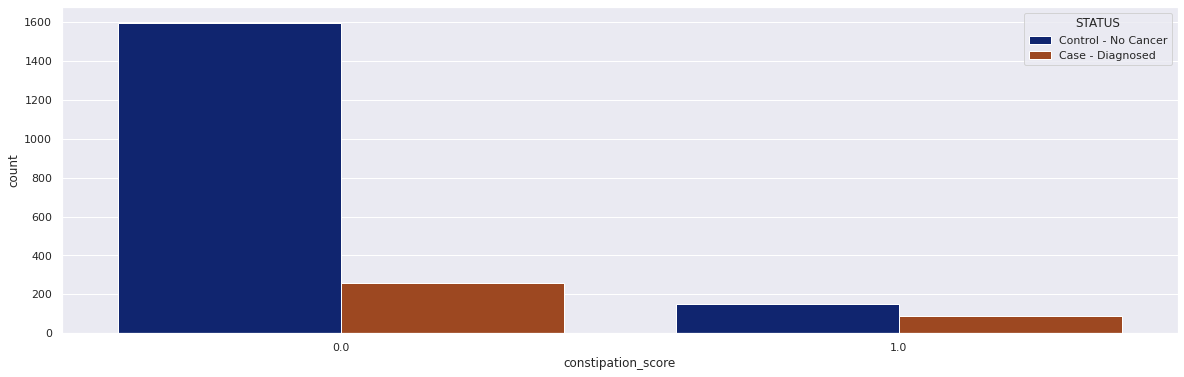



RB_score


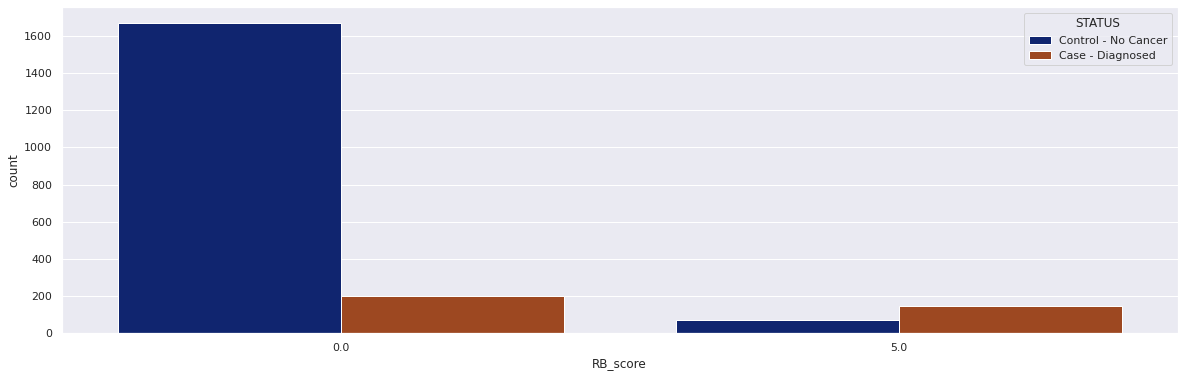



FOB_score


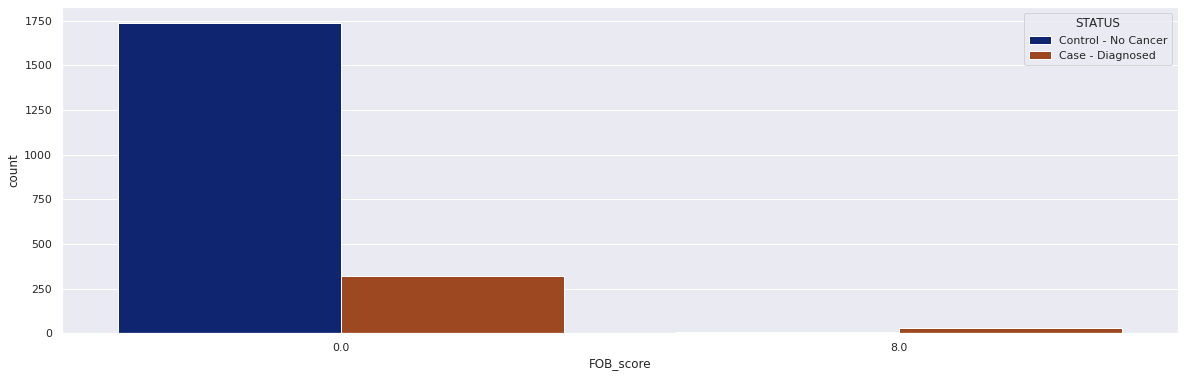



anaemia_score


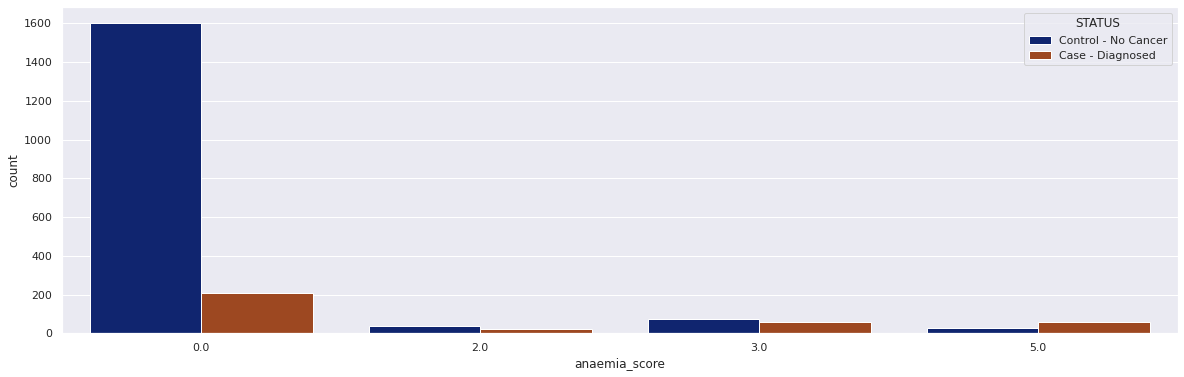

In [196]:
# Bivariate analysis - symptom scores vs. cancer case status
for i in crc_symp_score_cols:
    print(i)
    plt.figure(figsize=(20, 6))
    sns.countplot(x = df_crc_select[i], hue='STATUS', data=df_crc_select)
    plt.show()
    print('\n')

#### Diabetes related specs vs. cancer case status

diabetes_tested


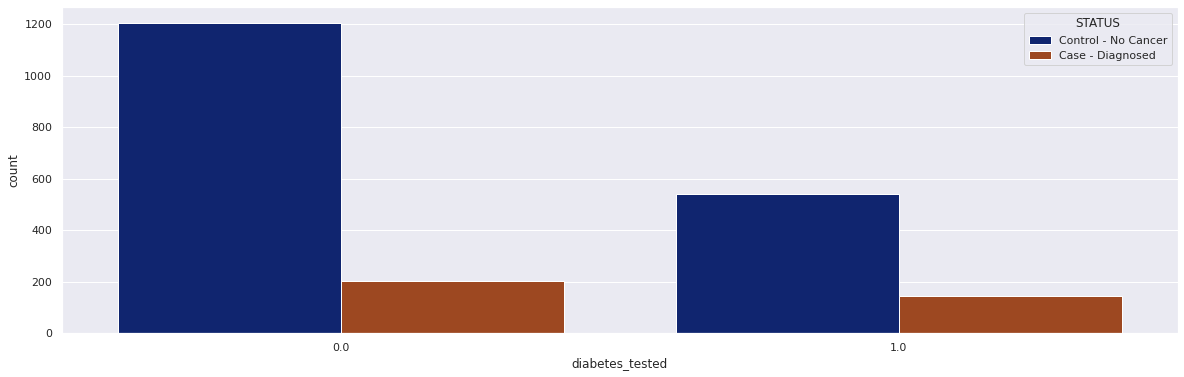



labelled_diabetic


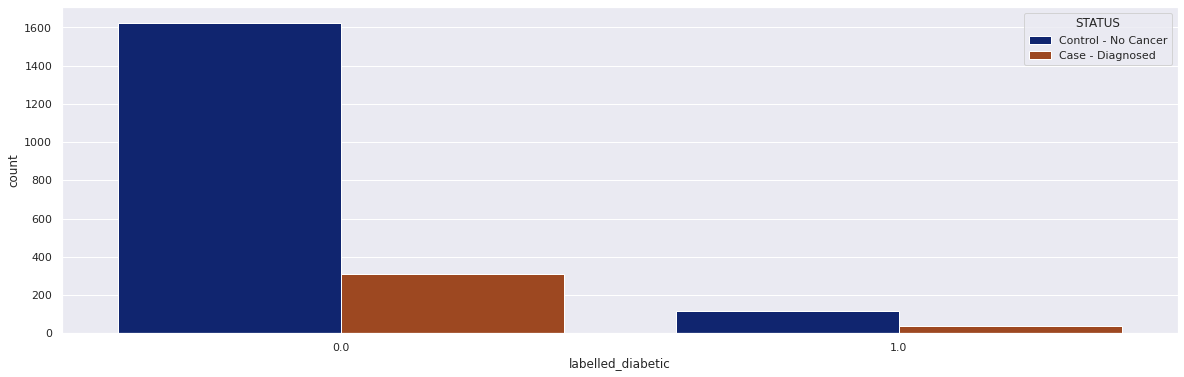



diabetic_control_poor


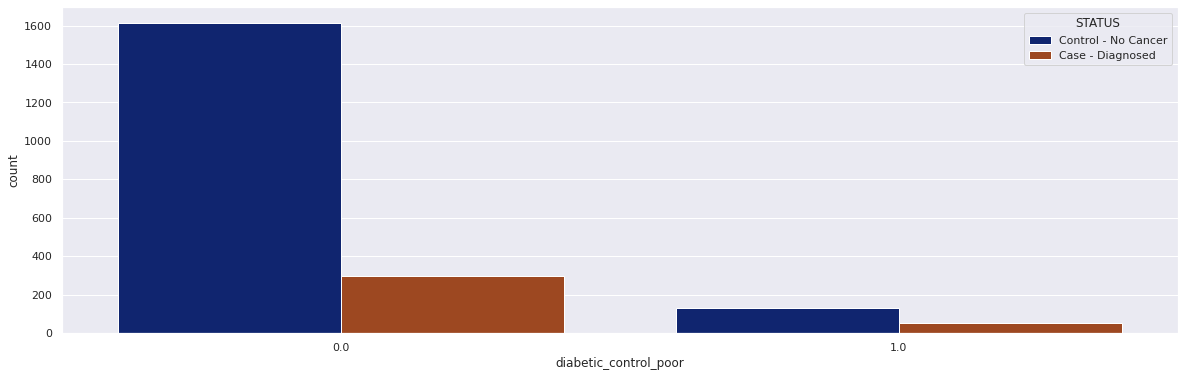



sugar_score


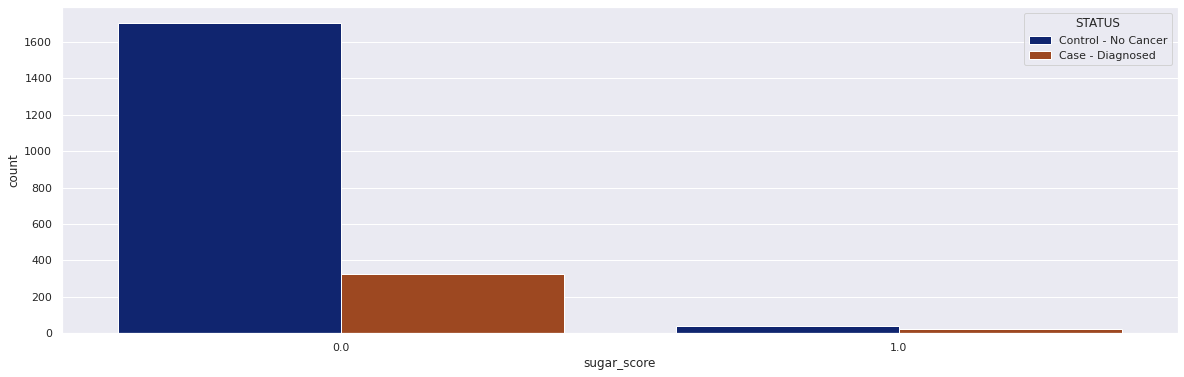

In [194]:
# Bivariate analysis - diabetes specs vs. cancer case status
for i in crc_diabetes_related_cols:
    print(i)
    plt.figure(figsize=(20, 6))
    sns.countplot(x = df_crc_select[i], hue='STATUS', data=df_crc_select)
    plt.show()
    print('\n')

### Multivariate Analysis

#### Selected Symptoms correlation map

In [231]:
df_select_symp = df_crc_select[crc_symp_cols]

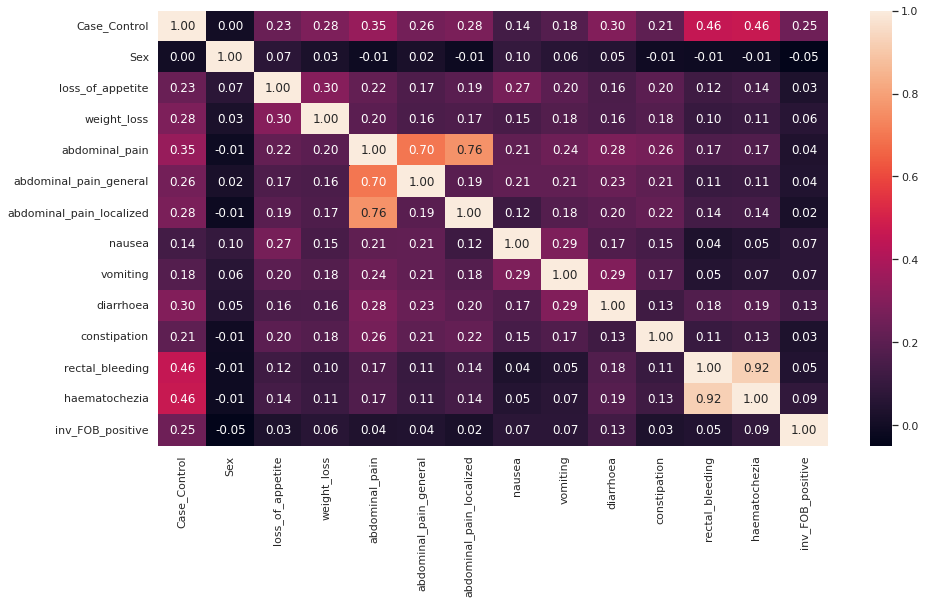

In [232]:
#Multivariate analysis of symptoms
plt.figure(figsize=(15,8))
sns.heatmap(df_select_symp.corr(),annot=True, fmt='0.2f')

#### Selected Symptoms clustermap

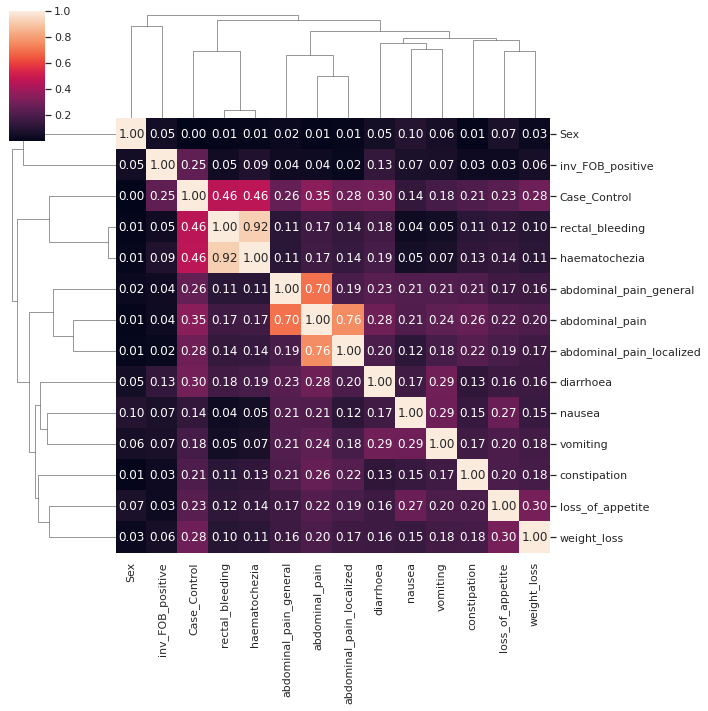

In [233]:
sns.clustermap(df_select_symp.corr().abs(),annot=True, fmt = ".2f")

#### Symptom frequencies correlation clustermap

In [212]:
df_sym_freq = df_crc_select[crc_symp_freq_cols]

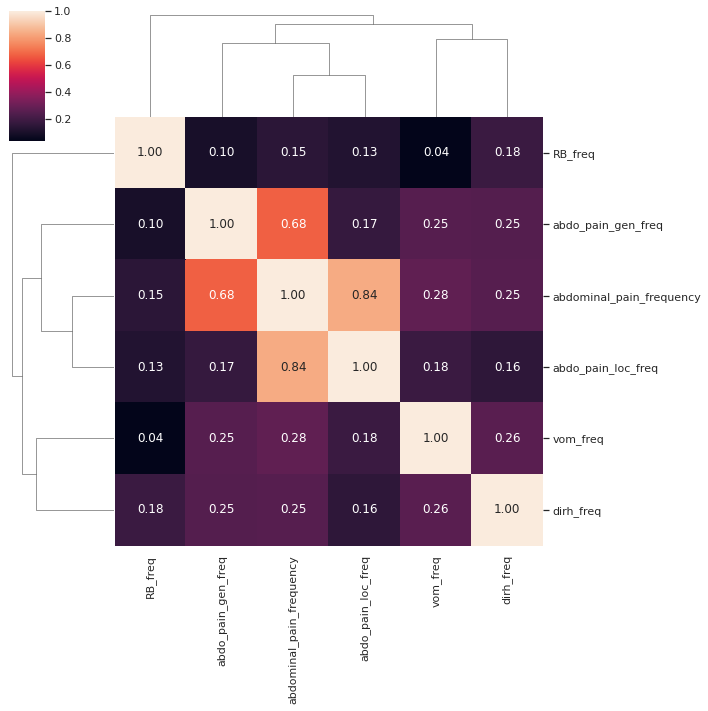

In [213]:
sns.clustermap(df_sym_freq.corr().abs(),annot=True, fmt = ".2f")

#### Symptoms scores correlation clustermap

In [210]:
df_sym_scores = df_crc_select[crc_symp_score_cols]

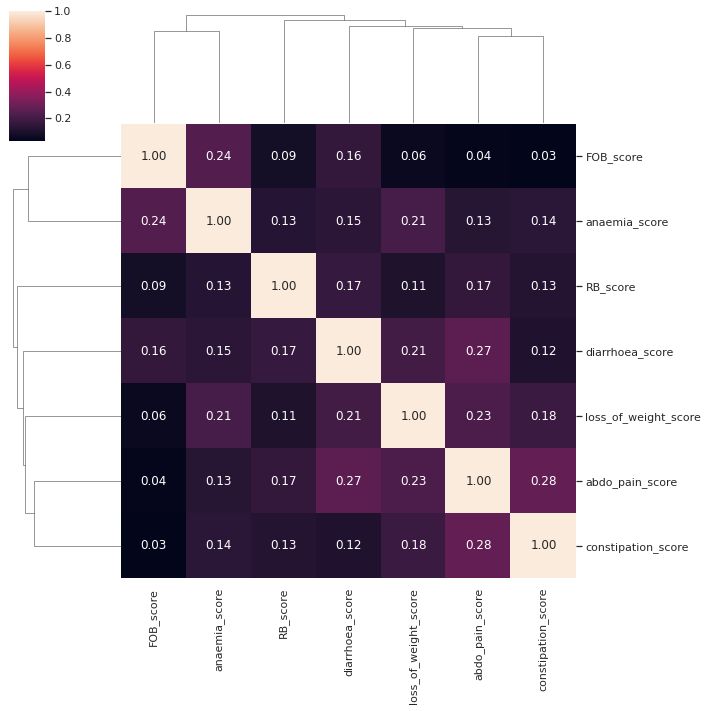

In [211]:
sns.clustermap(df_sym_scores.corr().abs(),annot=True, fmt = ".2f")